In [20]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))

# ----------- local imports ----------- 
from utils import show_images, make_grid
from constants import TRAIN_PATH, TRAIN_JSON_PATH
from FashionDataset import FashionDataset, BottomCenterCrop

In [8]:
import torch
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from diffusers import AutoencoderKL
from controlnet_aux import OpenposeDetector
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device=device).manual_seed(42)
dtype = torch.bfloat16
# dtype = torch.float32

In [9]:
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet").to(device)

/home/aliaagheis/miniconda3/envs/fast_env/lib/python3.12/site-packages/controlnet_aux/open_pose/body.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.t

In [19]:
image_resize = (1101, 750) # divided by 3 (H, W)
image_crop = (1096, 744) # H, W

transform = transforms.Compose([
    transforms.Resize(image_resize),
    BottomCenterCrop(image_crop),  # Custom bottom-center crop
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [21]:
import json

with open(TRAIN_JSON_PATH, 'r') as f:
    train_json = json.load(f)

In [ ]:
poses = []
for entry in tqdm(train_json):
    src, tar = entry['source_image'], entry['target_image']
    src, tar = Image.open(TRAIN_PATH / src), Image.open(TRAIN_PATH / tar)
    src, tar = transform(src), transform(tar)
    src, tar = show_images(src), show_images(tar)
    
    # concat them in width dimension
    src_tar = Image.new("RGB", (src.width * 2, src.height))
    src_tar.paste(src, (0, 0))
    src_tar.paste(tar, (src.width, 0))
    
    src_tar_pose = openpose(src_tar, detect_resolution=src_tar.size[1]).resize(src_tar.size, Image.BICUBIC)
    
    src_pose = src_tar_pose.crop((0, 0, src.width, src_tar.height))  # Left half
    tar_pose = src_tar_pose.crop((src.width, 0, src_tar.width, src_tar.height))  # Right half
    
    poses.append((entry['source_image'], src_pose))
    poses.append((entry['target_image'], tar_pose))
    break

In [10]:
src_tar_img = show_images(xb['src_tar'])

src_tar_pose = openpose(src_tar_img, detect_resolution=src_tar_img.size[1], include_body=True, include_face=True).resize(src_tar_img.size, Image.BICUBIC)

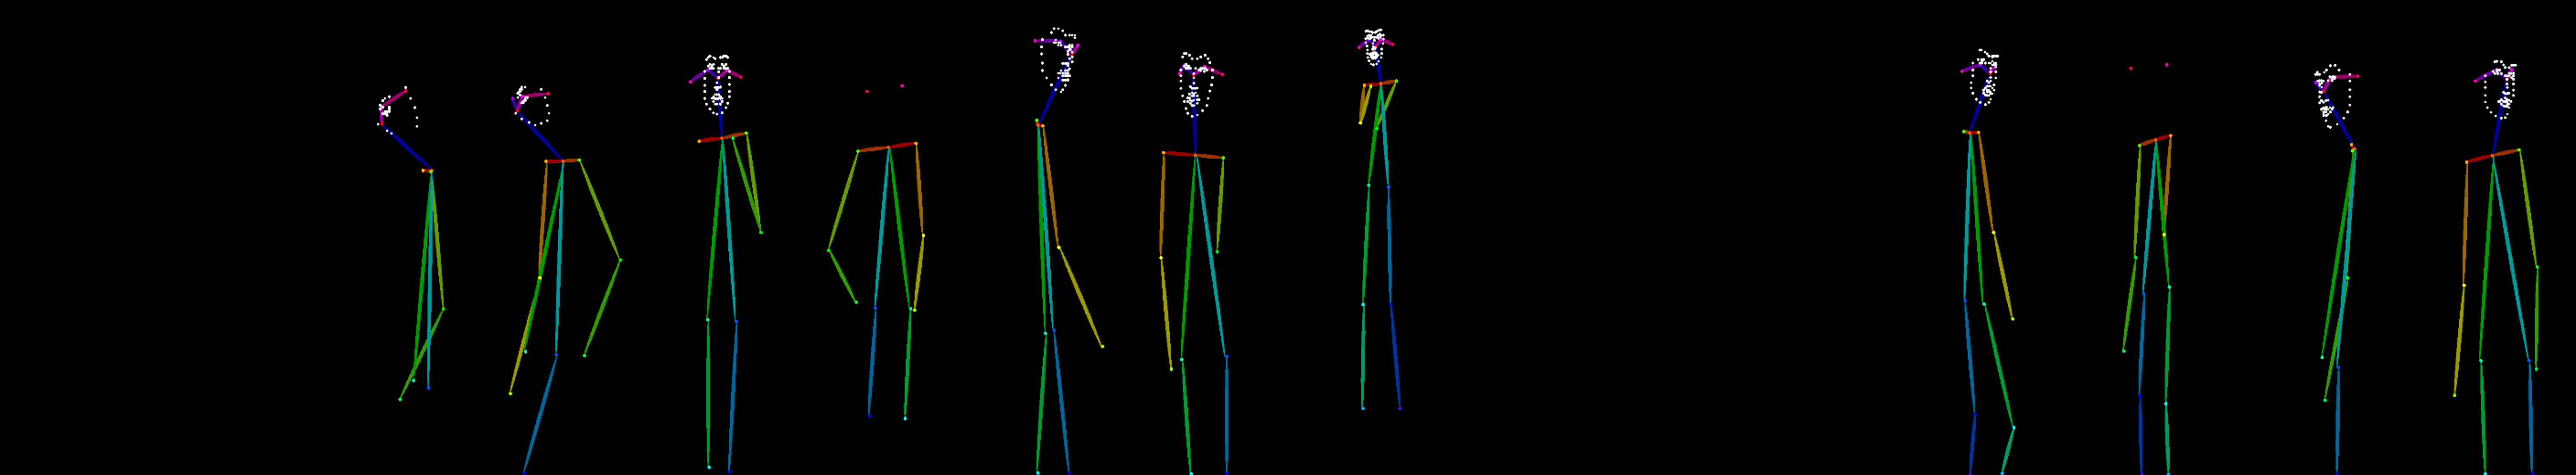

In [11]:
src_tar_pose